## Testcase
This test happens after the initial hdbscan hyper parameters optimization on a set of three variables, a few timeaggs, and a few lags, Dimensions have been reduced with both mean and spatcov. The ideas for the notebook are the following.
* check correctness of lagging
* check smoothness of the timeseries. Should differ over the timescales involved.
* check trends. Mean vs spatcov suffer differently?
* importance of mean vs spatcov. Dependent on size of the region?
* fit statistical models per mid-point lag vs per separation

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale

In [2]:
basedir = Path('/scistor/ivm/jsn295/spatcov/')
precfile = basedir / 'precursor.multiagg.parquet'
predfile = basedir / 'response.multiagg.trended.parquet'

In [3]:
precs = pd.read_parquet(precfile)
preds = pd.read_parquet(predfile)

### Making sense of the time dimension
Left lag vs separation

Only after 1981 the data is complete. Before that swvl13 from ERA5-Land misses. After selecting the lags (left stamped) make sense. The amount of missing points at the beginning within one year (from March to August) due to lagging is as expected

In [4]:
precs.loc['1981-01-01':'1981-06-06',:].isnull().sum().groupby('lag').mean()

lag
-1      1
-13    13
-20    20
-26    26
-30    30
-31    31
-36    36
-37    37
-49    49
-60    60
-7      7
dtype: int64

In [5]:
precs.columns.droplevel([0,1,-2,-1]).drop_duplicates() # Unique lag, separation combinations.

MultiIndex([( -7,  -6),
            ( -1,   0),
            (-37, -30),
            (-26, -19),
            (-13,  -6),
            ( -7,   0),
            (-60, -30),
            (-49, -19),
            (-36,  -6),
            (-30,   0),
            (-31, -30),
            (-20, -19)],
           names=['lag', 'separation'])

There exists some overlap in the separations. It will be interesting to see if the importance order of the timescales at e.g. -6 depends on the timescale of the response.

### Statistical properties

In [23]:
# Some quality function? Extracting linear trend, stdev, smoothness (auto-corr)
def get_properties(series, submonths: list = None, scale_trend_intercept = True):
    """ submonths should be a list of integers 
    Returns a Series object
    """
    if not submonths is None:
        series = series.loc[series.index.month.map(lambda m: m in submonths)]
    std = series.std()
    mean = series.mean() 
    length = len(series)
    n_nan = series.isna().sum()
    series = series.dropna() # Remove nans
    lm = LinearRegression()
    if scale_trend_intercept:
        lm.fit(y = scale(series), X = series.index.year.values.reshape(-1,1))
    else:
        lm.fit(y = series, X = series.index.year.values.reshape(-1,1))
    trend = float(lm.coef_) # (standardized) coefficient / yr
    intercept = lm.intercept_
    # Smoothness is the autocorrelation at a lag of 1 day and 5 days.
    lag1 = pd.Series(series.values, index = series.index - pd.Timedelta('1D'), name = 'lag1')
    auto1 = pd.merge(left = series, right = lag1, left_index=True, right_index=True, how = 'inner').corr().iloc[0,-1]
    lag5 = pd.Series(series.values, index = series.index - pd.Timedelta('5D'), name = 'lag5')
    auto5 = pd.merge(left = series, right = lag5, left_index=True, right_index=True, how = 'inner').corr().iloc[0,-1]
    return(pd.Series({'std':std,'mean':mean,'length':length, 'n_nan':n_nan,'trend':trend, 'intercept':intercept, 'auto1': auto1, 'auto5': auto5}))

In [7]:
stats = precs.apply(get_properties, axis = 0)
stats

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were enc

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain to

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  war

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different l

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  war

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on t

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The stand

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain to

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  war

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation o

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging betw

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  war

variable    z300_nhnorm                                                      \
timeagg               1                                                       
lag                 -7                                                  -1    
separation          -6                                                   0    
clustid               0                         1                         0   
metric          spatcov         mean      spatcov         mean      spatcov   
std            2.961461  1143.392212    72.544029   494.251282   128.064819   
mean          -0.005349    14.853645    -0.019220    12.417463    -0.154643   
length      7544.000000  7544.000000  7544.000000  7544.000000  7544.000000   
n_nan        287.000000   287.000000   287.000000   287.000000    41.000000   
trend          0.001859     0.012267     0.005142     0.011832     0.008316   
intercept     -3.715154   -24.520842   -10.279520   -23.651197   -16.622971   
auto1          0.747379     0.917412     0.866337     0.895034     0.869988   
auto5          0.131501     0.385155     0.240398     0.307973     0.304691   

variable                swvl13_europe                                          \
timeagg                             7                                           
lag                               -37                                           
separation                        -30                                           
clustid                             0                          1                
metric             mean       spatcov         mean       spatcov         mean   
std          432.743134      0.000303     0.010829  6.510228e-05     0.019289   
mean          11.359239      0.000005    -0.000324 -3.697957e-07     0.000004   
length      7544.000000   7544.000000  7544.000000  7.544000e+03  7544.000000   
n_nan         41.000000   1811.000000  1811.000000  1.811000e+03  1811.000000   
trend          0.010459     -0.005596    -0.017754 -1.106092e-02     0.003197   
intercept    -20.907568     11.192057    35.508388  2.212184e+01    -6.393101   
auto1          0.909626      0.997687     0.998538  9.960446e-01     0.994795   
auto5          0.321620      0.948437     0.968418  9.160218e-01     0.885371   

variable    ...   sst_nhplus                                         \
timeagg     ...            1                                          
lag         ...          -1                                           
separation  ...           0                                           
clustid     ...            0                         1                
metric      ...      spatcov         mean      spatcov         mean   
std         ...     0.002743     0.370910     0.022884     0.286223   
mean        ...    -0.000002    -0.013414    -0.000133    -0.008264   
length      ...  7544.000000  7544.000000  7544.000000  7544.000000   
n_nan       ...    41.000000    41.000000    41.000000    41.000000   
trend       ...     0.008387     0.028070     0.006915     0.035318   
intercept   ...   -16.765665   -56.111756   -13.823466   -70.600912   
auto1       ...     0.976912     0.986894     0.990853     0.991621   
auto5       ...     0.805647     0.886365     0.903484     0.914378   

variable                                                                     \
timeagg                                                                       
lag                                                                           
separation                                                                    
clustid               2                         3                         4   
metric          spatcov         mean      spatcov         mean      spatcov   
std            0.018569     0.314307     0.001479     0.573413     0.053132   
mean          -0.000481     0.003898     0.000021     0.032409     0.000653   
length      7544.000000  7544.000000  7544.000000  7544.000000  7544.000000   
n_nan         41.000000    41.000000    41.000000   

In [95]:
stats.loc[('auto1','auto5'),:].groupby(['variable','timeagg'], axis = 1).mean()

variable sst_nhplus                     swvl13_europe                      \
timeagg          1         30        7             1         30        7    
auto1      0.986360  0.999499  0.996218      0.991608  0.999357  0.997535   
auto5      0.880347  0.988607  0.929337      0.916238  0.984411  0.946833   

variable z300_nhnorm                      
timeagg           1         30        7   
auto1       0.867629  0.996022  0.968581  
auto5       0.281889  0.932590  0.529980

Regular inituitions seem confirmed. the longer the timescale the greater the auto-correlation. Z300 has the fastest decay. Then, sst, and then swvl. The latter order is a bit surprising. Though this mixes all regions. Lags do not really matter a lot.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aabd8907a20>,
      dtype=object)

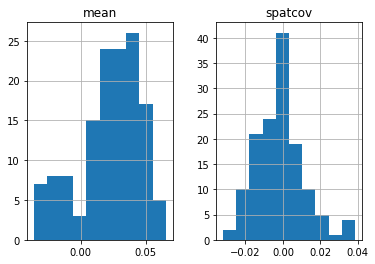

In [119]:
stats.loc['trend'].unstack(-1).hist()

The largest (standardized) trends seem to be in the mean, and are predominantly positive. Spatcov is distributed around zero. Because trend is largest in the mean, and because all series are scaled, also the intercept is largest for the mean series.

### Statistics of response variable

In [ ]:
respstats = preds.apply(get_properties, axis = 0)
respstats.columns = respstats.columns.droplevel([0,2])
respstats_unscaled = preds.apply(get_properties, axis = 0, **dict(scale_trend_intercept = False))
respstats_unscaled.columns = respstats_unscaled.columns.droplevel([0,2])

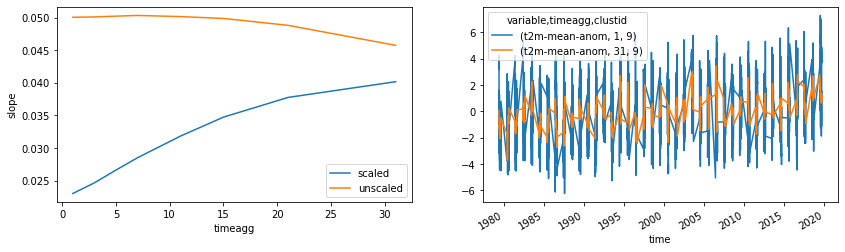

In [54]:
fig, axes = plt.subplots(ncols = 2, figsize = (14, 4))
respstats.loc['trend'].plot(ax = axes[0], label = 'scaled')
respstats_unscaled.loc['trend'].plot(label = 'unscaled', ax = axes[0])
axes[0].set_ylabel('slope')
axes[0].legend()
preds.loc[:,(slice(None),[1,31])].plot( ax = axes[1])
plt.show()

It seems to be the scaling that changes the sign of the slope. 31 day timeseries has of course a much lower standard deviation, divided by it, the series becomes relatively. This means that there is a trend signal in daily extremes, giving it a higher std and a lower scaled trend.

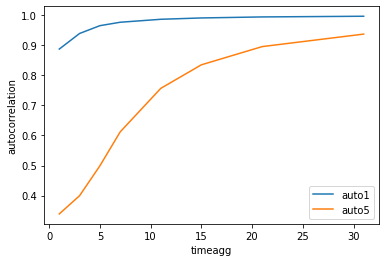

In [55]:
respstats.loc[['auto1','auto5']].T.plot()
plt.ylabel('autocorrelation')
plt.show()

### Importance of spatcov vs mean
Later on we distinguish between timescales. We want to train one model per separation. One per timescale.

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import detrend

In [148]:
def single_pass_forward_permute(classifier, data_in, data_out, scores = [r2_score, mean_squared_error], scorenames = ['r2','mse']):
    """
    Function that takes in a fitted regressor/classifier. Data in are X and data out is y. 
    Returns a dataframe with the columns of data_in (predictors) as index, and scores in the columns
    """
    outcomes = pd.DataFrame(index = data_in.columns, columns = pd.Index(scorenames,name = 'score'), dtype = 'float64')
    for variable in data_in.columns:
        temp = data_in.copy() # Make sure that we are not overwriting by reference
        temp[variable] = temp[variable].sample(n = len(temp), replace = False).values
        prediction = classifier.predict(X = temp) # Prediction for positive, which is lightning
        outcomes.loc[variable] = [score(data_out, prediction) for score in scores]
    # Add the reference forecast:
    prediction = classifier.predict(X = data_in)
    outcomes.loc[('reference',)] = [score(data_out, prediction) for score in scores]
    return outcomes

In [274]:
# Training & importance only on the summer data, full set. No train-test splits
def fit_and_importance(prec_timeaggs = 1, separations = 0, resp_timeagg = 1, detrend_resp = False):
    """
    Possible to supply lists of integers for prec_timeaggs and separations.
    Throws away nans (in practice: data before 1981)
    """
    X = precs.loc[precs.index.month.map(lambda m: m in [6,7,8]),(slice(None),prec_timeaggs,slice(None),separations, slice(None))]
    X = X.dropna()
    y = preds.loc[preds.index.month.map(lambda m: m in [6,7,8]), (slice(None),resp_timeagg,slice(None))]
    y = y.loc[X.index]
    if detrend_resp:
        y = pd.DataFrame(detrend(y, axis = 0), index = y.index, columns = y.columns)
    regr_forest = RandomForestRegressor(min_samples_leaf = 200)
    regr_forest.fit(X = X, y = y.values.ravel())
    builtin_imp = pd.Series(regr_forest.feature_importances_, index = X.columns, name = 'builtin')
    permute_imp = single_pass_forward_permute(regr_forest, X, y.values.ravel())
    return permute_imp.join(builtin_imp, how = 'outer')

In [275]:
test = fit_and_importance()
test_det = fit_and_importance(detrend_resp=True)

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [276]:
test_det

r2       mse  \
variable      timeagg lag separation clustid metric                        
reference                                             0.676245  1.417677   
sst_nhplus    1       -1  0          0       mean     0.676245  1.417677   
                                             spatcov  0.676178  1.417974   
                                     1       mean     0.676245  1.417677   
                                             spatcov  0.676245  1.417677   
                                     2       mean     0.675996  1.418770   
                                             spatcov  0.675889  1.419237   
                                     3       mean     0.675832  1.419489   
                                             spatcov  0.676003  1.418737   
                                     4       mean     0.676245  1.417677   
                                             spatcov  0.676245  1.417677   
swvl13_europe 1       -1  0          0       mean     0.675939  1.419020   
                                             spatcov  0.675640  1.420329   
                                     1       mean     0.676245  1.417677   
                                             spatcov  0.671357  1.439082   
z300_nhnorm   1       -1  0          0       mean     0.674723  1.424345   
                                             spatcov -0.709639  7.486274   

                                                       builtin  
variable      timeagg lag separation clustid metric             
reference                                                  NaN  
sst_nhplus    1       -1  0          0       mean     0.000000  
                                             spatcov  0.000050  
                                     1       mean     0.000000  
                                             spatcov  0.000000  
                                     2       mean     0.000346  
                                             spatcov  0.000342  
                                     3       mean     0.000470  
                                             spatcov  0.000247  
                                     4       mean     0.000000  
                                             spatcov  0.000000  
swvl13_europe 1       -1  0          0       mean     0.000237  
                                             spatcov  0.000911  
                                     1       mean     0.000000  
                                             spatcov  0.004280  
z300_nhnorm   1       -1  0          0       mean     0.001474  
                                             spatcov  0.991642

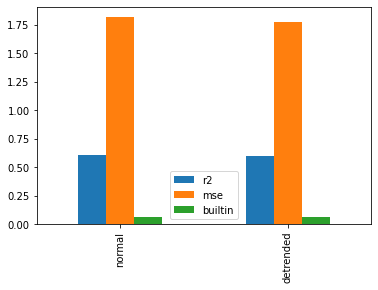

In [277]:
pd.concat([test.mean(axis = 0), test_det.mean(axis = 0)], keys = ['normal','detrended']).unstack(-1).plot.bar()

* From this small test you can first of all see that overall the random forest is just better at predicting the detrended response. (slightly higher r2 + lower mse)
* For spatcov vs mean you see that spatcov is always the better one.
* But then this small test is also very influenced by one dominant precursor. At this timeagg = 1, separation = 0, you find that the spatial covariance with z300 is the only important predictor. It gets all the credit. And swvl13 cluster 
* It would be interesting to see whether spatcov vs mean also holds for other scales and trended data.

In [278]:
multi_time_one_sep = fit_and_importance(prec_timeaggs=[1,7],separations=-6,resp_timeagg=3, detrend_resp=True)

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [279]:
multi_time_one_sep

r2       mse  \
variable      timeagg lag separation clustid metric                        
reference                                             0.219091  2.955757   
sst_nhplus    1       -7  -6         0       mean     0.219091  2.955757   
                                             spatcov  0.170724  3.138831   
                                     1       mean     0.218653  2.957418   
                                             spatcov  0.218819  2.956789   
                                     2       mean     0.216904  2.964038   
                                             spatcov  0.218787  2.956910   
                                     3       mean     0.219011  2.956063   
                                             spatcov  0.217790  2.960682   
                                     4       mean     0.217836  2.960507   
                                             spatcov  0.218893  2.956508   
              7       -13 -6         0       mean     0.218666  2.957369   
                                             spatcov  0.216340  2.966170   
                                     1       mean     0.218985  2.956160   
                                             spatcov  0.184499  3.086692   
                                     2       mean     0.218614  2.957565   
                                             spatcov  0.218562  2.957761   
                                     3       mean     0.218599  2.957621   
                                             spatcov  0.208988  2.993998   
                                     4       mean     0.217589  2.961445   
                                             spatcov  0.212884  2.979253   
                                     5       mean     0.217477  2.961868   
                                             spatcov  0.216584  2.965249   
                                     6       mean     0.218784  2.956921   
                                             spatcov  0.217381  2.962229   
swvl13_europe 1       -7  -6         0       mean     0.218259  2.958909   
                                             spatcov  0.218218  2.959062   
                                     1       mean     0.218731  2.957121   
                                             spatcov  0.215052  2.971046   
                                     2       mean     0.218994  2.956127   
                                             spatcov  0.218959  2.956257   
                                     3       mean     0.214927  2.971521   
                                             spatcov  0.217761  2.960792   
              7       -13 -6         0       mean     0.219055  2.955894   
                                             spatcov  0.195492  3.045083   
                                     1       mean     0.218262  2.958898   
                                             spatcov  0.213151  2.978243   
                                     2       mean     0.218645  2.957447   
                                             spatcov  0.207709  2.998840   
z300_nhnorm   1       -7  -6         0       mean     0.217144  2.963129   
                                             spatcov  0.219023  2.956015   
                                     1       mean     0.219091  2.955757   
                                             spatcov  0.131626  3.286818   
              7       -13 -6         0       mean     0.218781  2.956932   
                                             spatcov  0.218978  2.956185   
                                     1       mean     0.214430  2.973401   
                                             spatcov  0.218980  2.956179   
                                     2       mean     0.208029  2.997629   
                                             spatcov  0.218282  2.958822   
                                     3       mean     0.216995  2.963692   
                                             spatcov  0.217974  2.959987   

                               

The above configuration gives an interesting result. For z300 and sst the biggest signal gains are at the shortest timescale. However, for swvl13 it is the greece cluster at 7 day aggregation that has most information. This makes me wonder if this changes when really trying to predict the heatwaves, like tmax. Also, the ordering/results are of course variable, dependent on the random fitting in the forest. In the end we are going to need splits.

In [280]:
def select_most_important(df, groups = ['variable','separation'], return_full = True):
    """
    Selecting the most important cluster/timescale per variable per separation. Usually the frame is already unique to one separation and its fitted model
    Returns either the full index or only (timeagg,clustid,metric). Returns that order for completeness.
    """
    order = ['timeagg','clustid','metric']
    levels = [ df.index.names.index(s) for s in order]
    keys = []
    results = []
    grouped = df.groupby(groups)
    for key, group in grouped:
        r2 = group.idxmin().loc[['r2']] # Lowest for r2
        mse_builtin = group.idxmax().loc[['mse','builtin']] # Highest for the others
        most_important = pd.concat([r2,mse_builtin], axis = 0)
        keys.append(key)
        if not return_full: # Selecting from this series of tuples
            most_important = most_important.map(lambda x: tuple(np.array(x, dtype = 'object')[levels])) # Conversion to array as this allows multiple disjoint value
        results.append(most_important)
    return pd.concat(results, keys = keys, axis = 1).T, order

In [281]:
ret, _ = select_most_important(multi_time_one_sep.drop('reference'), groups = ['variable'], return_full=True)
ret2, _ = select_most_important(multi_time_one_sep.drop('reference'), groups = ['variable','timeagg'], return_full=True)

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [282]:
ret

,r2,mse,builtin
sst_nhplus,"(sst_nhplus, 1, -7, -6, 0, spatcov)","(sst_nhplus, 1, -7, -6, 0, spatcov)","(sst_nhplus, 1, -7, -6, 0, spatcov)"
swvl13_europe,"(swvl13_europe, 7, -13, -6, 0, spatcov)","(swvl13_europe, 7, -13, -6, 0, spatcov)","(swvl13_europe, 7, -13, -6, 0, spatcov)"
z300_nhnorm,"(z300_nhnorm, 1, -7, -6, 1, spatcov)","(z300_nhnorm, 1, -7, -6, 1, spatcov)","(z300_nhnorm, 1, -7, -6, 1, spatcov)"


In [283]:
ret2

r2  \
sst_nhplus    1      (sst_nhplus, 1, -7, -6, 0, spatcov)   
              7     (sst_nhplus, 7, -13, -6, 1, spatcov)   
swvl13_europe 1      (swvl13_europe, 1, -7, -6, 3, mean)   
              7  (swvl13_europe, 7, -13, -6, 0, spatcov)   
z300_nhnorm   1     (z300_nhnorm, 1, -7, -6, 1, spatcov)   
              7       (z300_nhnorm, 7, -13, -6, 2, mean)   

                                                     mse  \
sst_nhplus    1      (sst_nhplus, 1, -7, -6, 0, spatcov)   
              7     (sst_nhplus, 7, -13, -6, 1, spatcov)   
swvl13_europe 1      (swvl13_europe, 1, -7, -6, 3, mean)   
              7  (swvl13_europe, 7, -13, -6, 0, spatcov)   
z300_nhnorm   1     (z300_nhnorm, 1, -7, -6, 1, spatcov)   
              7       (z300_nhnorm, 7, -13, -6, 2, mean)   

                                                 builtin  
sst_nhplus    1      (sst_nhplus, 1, -7, -6, 0, spatcov)  
              7     (sst_nhplus, 7, -13, -6, 1, spatcov)  
swvl13_europe 1      (swvl13_europe, 1, -7, -6, 3, mean)  
              7  (swvl13_europe, 7, -13, -6, 0, spatcov)  
z300_nhnorm   1     (z300_nhnorm, 1, -7, -6, 1, spatcov)  
              7       (z300_nhnorm, 7, -13, -6, 2, mean)

When comparing the two tables above you still see dominance of spatcov. Except for when you select the suboptimal predictor of the 7 day regions in z300. But selecting at each separation, for each variable the best timescale and region, then everything is spatcov. Weirdly, when I look up the SSt clusters for both the timescales, these clustids are in the Indian Ocean.

Now let's see whether the same holds for a similar but trended scenario.

In [284]:
multi_time_one_sep_tr = fit_and_importance(prec_timeaggs=[1,7],separations=-6,resp_timeagg=3, detrend_resp=False)
ret_tr, _ = select_most_important(multi_time_one_sep_tr.drop('reference'), groups = ['variable'], return_full=True)

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [285]:
print('trended reference skill \n',multi_time_one_sep_tr.loc['reference',['r2','mse']])
print('detrended reference skill \n',multi_time_one_sep.loc['reference',['r2','mse']])

trended reference skill 
                                              r2       mse
timeagg lag separation clustid metric                    
                                       0.252968  3.029333
detrended reference skill 
                                              r2       mse
timeagg lag separation clustid metric                    
                                       0.219091  2.955757


In [272]:
ret_tr

,r2,mse,builtin
sst_nhplus,"(sst_nhplus, 1, -7, -6, 0, spatcov)","(sst_nhplus, 1, -7, -6, 0, spatcov)","(sst_nhplus, 1, -7, -6, 0, spatcov)"
swvl13_europe,"(swvl13_europe, 7, -13, -6, 0, spatcov)","(swvl13_europe, 7, -13, -6, 0, spatcov)","(swvl13_europe, 7, -13, -6, 0, spatcov)"
z300_nhnorm,"(z300_nhnorm, 1, -7, -6, 1, spatcov)","(z300_nhnorm, 1, -7, -6, 1, spatcov)","(z300_nhnorm, 1, -7, -6, 1, spatcov)"


Exactly the same important regions. Also here skill is slightly lower in terms of r2, slightly higher in terms of MSE (Random forest learning the trend leaves less room to use other information probably). Investigate with more scores?

### Dependence of best timescales and skill on response timescale

### Ordering of timescales at separation 16
Does SST and soilm do something interesting?

In [38]:
# Train a good RandomForest
# Check if we can do hyperparameter optimization.
from sklearn.model_selection import KFold
leaf_sizes = np.arange(1,800,20)
n_folds = 8
results = xr.DataArray(np.empty((len(leaf_sizes),n_folds,2)), dims = ('leaf_size','fold','metric'), coords = dict(leaf_size = leaf_sizes, fold = np.arange(n_folds),metric = ['r2','mse']))
for ind, alpha in enumerate(leaf_sizes):
    kf = KFold(n_splits=n_folds)
    k = 0
    for train_index, val_index in kf.split(X):
        X_t_fold, X_v_fold = X.iloc[train_index], X.iloc[val_index]
        y_t_fold, y_v_fold = y_det.iloc[train_index], y_det.iloc[val_index]
        regr = RandomForestRegressor(min_samples_leaf = alpha)
        regr.fit(X_t_fold,y_t_fold)
        predictions = regr.predict(X_v_fold)
        r2 = r2_score(y_v_fold, predictions)
        mse = mean_squared_error(y_v_fold, predictions)
        results[ind,k,:] = [r2, mse]
        k += 1

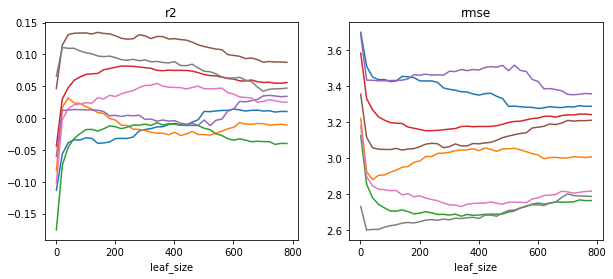

In [39]:
df = results.to_dataframe(name = 'score').unstack([1,2])
df.columns = df.columns.droplevel(0)
fig, [ax1,ax2] = plt.subplots(ncols=2, figsize = (10,4))
df.loc[:,(slice(None),'r2')].plot(ax = ax1, legend = False, title = 'r2')
df.loc[:,(slice(None),'mse')].plot(ax = ax2, legend = False, title = 'rmse')

In [31]:
# So the model should have leaf_size = 200

regr_forest = RandomForestRegressor(min_samples_leaf = 200)
regr_forest.fit(X = X, y = y)

def single_pass_forward_permute(classifier, data_in, data_out, scores = [r2_score, mean_squared_error], scorenames = ['r2','mse']):
    outcomes = pd.DataFrame(index = data_in.columns, columns = pd.Index(scorenames,name = 'score'))
    for variable in data_in.columns:
        temp = data_in.copy() # Make sure that we are not overwriting by reference
        temp[variable] = temp[variable].sample(n = len(temp), replace = False).values
        prediction = classifier.predict(X = temp) # Prediction for positive, which is lightning
        outcomes.loc[variable] = [score(data_out, prediction) for score in scores]
    # Add the reference forecast:
    prediction = classifier.predict(X = data_in)
    outcomes.loc['reference'] = [score(data_out, prediction) for score in scores]
    return outcomes
train_perm = single_pass_forward_permute(regr_forest, X, y)

In [37]:
train_perm

score,r2,mse
"(z300_nhmin, 1, -7, 0)",0.101883,3.19245
"(z300_nhmin, 1, -7, 1)",-0.035663,3.68137
"(z300_nhmin, 1, -7, 2)",0.100565,3.19713
"(z300_nhmin, 1, -7, 3)",0.0659045,3.32033
reference,0.103219,3.18769
